# Loading data and selecting features of interest

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

phishing = pq.read_table('floor/phishing_2307.parquet')
benign = pq.read_table('floor/benign_2307.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ICC
    "ip_v4_ratio",
    "ip_a_aaaa_to_all_ratio",
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    "dns_SOA_count",
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ICC
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    "tls_root_cert_lifetime",
    "tls_leaf_cert_lifetime",
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ICC
    "tls_has_tls",
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_sld_len",
    "lex_sld_norm_entropy", # <-- newly added feature on 24-09-29
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",
    
    # Newly added for ICC
    "lex_bigram_matches",
    "lex_trigram_matches",
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ICC
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ICC
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev"  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]

# Handle NaNs
df.fillna(-1, inplace=True)

df

Number of used features: 128
No. of available unused features: 0


,label,ip_mean_average_rtt,ip_entropy,ip_count,ip_v4_ratio,ip_a_aaaa_to_all_ratio,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,dns_A_count,...,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy,geo_countries_count,geo_continent_hash,geo_countries_hash,geo_lat_stdev,geo_lon_stdev
0,misp_2307:phishing,93.0610,1.0,2,1.0,1.0,1.0,-0.0,1.0,2,...,0,13.0,0.249146,23.0,0.149881,1,2,1800,0.00000,0.0000
1,misp_2307:phishing,0.0000,-0.0,1,1.0,1.0,-0.0,-0.0,1.0,1,...,0,0.0,0.000000,0.0,0.000000,1,3,184,0.00000,0.0000
2,misp_2307:phishing,-1.0000,-0.0,0,0.0,0.0,-1.0,-1.0,-1.0,0,...,0,0.0,0.000000,0.0,0.000000,0,0,0,0.00000,0.0000
3,misp_2307:phishing,3.4960,-0.0,1,0.0,0.0,-0.0,-0.0,1.0,0,...,0,19.0,0.182703,23.0,0.154588,1,1,600,0.00000,0.0000
4,misp_2307:phishing,0.0000,-0.0,1,1.0,1.0,-0.0,-0.0,1.0,1,...,0,0.0,0.000000,0.0,0.000000,1,0,144,0.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469560,benign_2307:unknown,165.7385,-0.0,2,1.0,1.0,-0.0,-0.0,1.0,2,...,0,10.0,0.332193,26.0,0.143050,1,2,1800,0.00000,0.0000
469561,benign_2307:unknown,3.8575,-0.0,2,0.5,1.0,-0.0,1.0,2.0,1,...,28,10.0,0.292193,23.0,0.157442,1,2,1800,0.00000,0.0000
469562,benign_2307:unknown,0.0000,1.0,2,1.0,1.0,1.0,-0.0,1.0,2,...,0,13.0,0.249146,23.0,0.149881,1,10,172,0.00000,0.0000
469563,benign_2307:unknown,20.5390,-0.0,2,0.5,1.0,-0.0,-0.0,1.0,1,...,64,0.0,0.000000,0.0,0.000000,1,6,130,1.19615,2.3587


In [2]:
# create train and test sets
from config import Config
from sklearn.model_selection import train_test_split

# lets use only a fraction of the dataset to quickly iterate on hyperparameter values
df = df.sample(frac=1).reset_index(drop=True)
# df = df.sample(frac = 0.1)

#TODO extract label names from config files
# benign_label = list(Config.COLLECTIONS.keys())[0]
# misp_label = list(Config.COLLECTIONS.keys())[1]
#class_map = {"benign_cesnet_union_2307:unknown": 0, "misp_2307:phishing": 1}
#class_map = {"cesnet2:unknown": 0, "misp_2307:phishing": 1}
class_map = {"benign_2307:unknown": 0, "misp_2307:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix


X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

default_params = {
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "random_state": 42,
    "max_leaf_nodes": None,
    "min_impurity_decrease": 0.0,
    "ccp_alpha": 0.0
}

## Finding values of meaningful magnitudes
In the first experiment, lets grid search one feature at the time find to find meaningful values faster

In [15]:
import math

def linear(min_value, max_value, n=3, rounded=False):
    step = (max_value - min_value) / (n - 1)
    values = [min_value + i * step for i in range(n)]
    return [round(x) for x in values] if rounded else values

def quadratic(min_value, max_value, n=3, rounded=False):
    values = [x*x for x in linear(min_value, math.sqrt(max_value), n)]
    return [round(x) for x in values] if rounded else values

params_v1 = {
    "max_depth": linear(2, 30, n=10, rounded=True),
    "min_samples_split": quadratic(2, 50, n=10, rounded=True),
    "min_samples_leaf": quadratic(2, 50, n=10, rounded=True),
    "min_weight_fraction_leaf": quadratic(0.0, 0.49, n=10),
    "max_leaf_nodes": quadratic(2, 250, n=10, rounded=True),
    "min_impurity_decrease": quadratic(0.0, 0.5, n=10),
    "ccp_alpha": linear(0.0, 0.5, n=10)
}

params_v2_01 = {
    "max_depth": linear(5, 30, n=10, rounded=True),
    "min_samples_split": quadratic(2, 50, n=10, rounded=True),
    "min_samples_leaf": quadratic(2, 10, n=10, rounded=True),
    "min_weight_fraction_leaf": quadratic(0.0, 0.01, n=10),
    "max_leaf_nodes": quadratic(50, 1000, n=10, rounded=True),
    "min_impurity_decrease": quadratic(0.0, 0.01, n=10),
    "ccp_alpha": linear(0.0, 0.01, n=10)
}

params_v21_1 = {
    "max_depth": linear(5, 30, n=5, rounded=True),
    "min_samples_split": quadratic(2, 50, n=5, rounded=True),
    "min_samples_leaf": quadratic(2, 10, n=5, rounded=True),
    "min_weight_fraction_leaf": quadratic(0.0, 0.01, n=5),
    "max_leaf_nodes": quadratic(50, 1000, n=5, rounded=True),
    "min_impurity_decrease": quadratic(0.0, 0.01, n=5),
    "ccp_alpha": linear(0.0, 0.01, n=5)
}

params_v3 = {
    "max_depth": linear(5, 30, n=10, rounded=True),
    "min_samples_split": linear(2, 50, n=10, rounded=True),
    "min_samples_leaf": linear(2, 10, n=10, rounded=True),
    # "min_weight_fraction_leaf": quadratic(0.0, 0.01, n=5),
    "max_leaf_nodes": linear(50, 500, n=10, rounded=True),
    # "min_impurity_decrease": quadratic(0.0, 0.01, n=5),
    # "ccp_alpha": linear(0.0, 0.01, n=5)
}

test_params = params_v3

Grid Search - max_depth: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37max_depth/s]


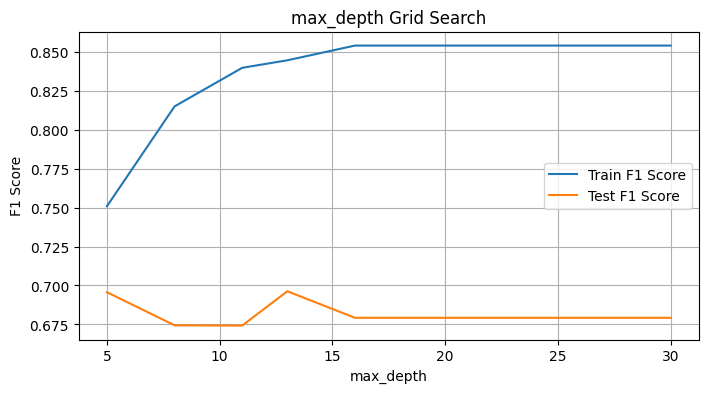

Best max_depth: 13
Best Test F1 Score: 0.6962962962962962


Grid Search - min_samples_split: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.23min_samples_split/s]


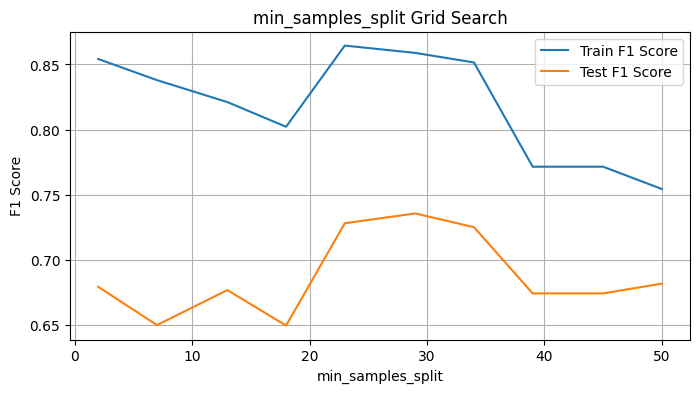

Best min_samples_split: 29
Best Test F1 Score: 0.7355371900826447


Grid Search - min_samples_leaf: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.51min_samples_leaf/s]


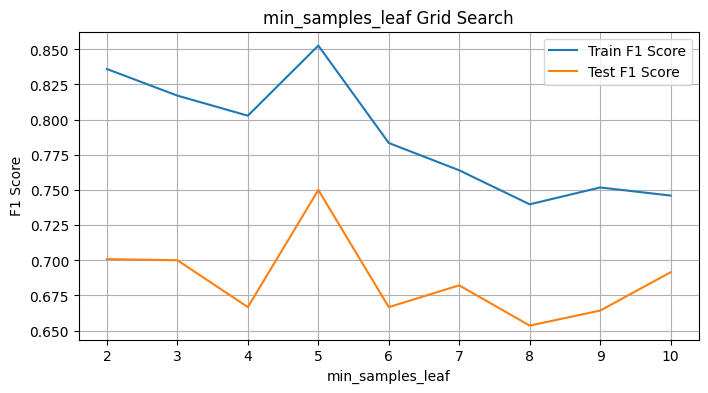

Best min_samples_leaf: 5
Best Test F1 Score: 0.75


Grid Search - max_leaf_nodes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.69max_leaf_nodes/s]


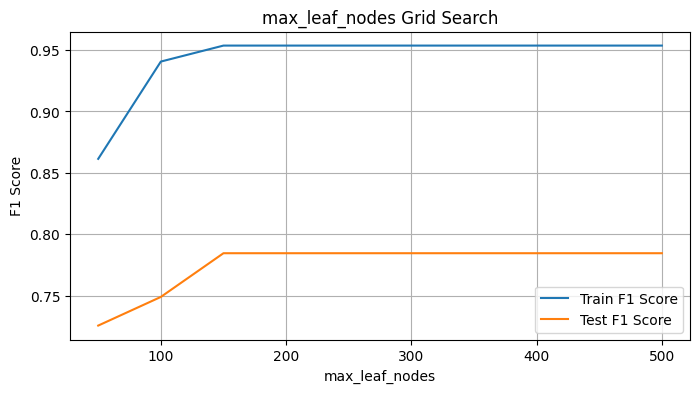

Best max_leaf_nodes: 150
Best Test F1 Score: 0.7844827586206897


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm  # Import tqdm for progress bars
from sklearn.metrics import f1_score

# Define a function to perform Grid Search for a given parameter
def perform_grid_search(param_name, param_values, estimator, X_train, y_train, X_test, y_test):
    param_values_for_plot = []  # Store parameter values for plotting
    train_f1_scores, test_f1_scores = [], []
    best_score, best_param_value = None, None

    # Wrap the loop with tqdm for a progress bar
    for value in tqdm(param_values, desc=f"Grid Search - {param_name}", unit=f"{param_name}"):
        params = default_params.copy()
        params[param_name] = value

        # Create and fit the classifier with the current parameter value
        clf = estimator(**params)
        clf.fit(X_train, y_train)

        # Calculate train and test F1 scores
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)
        train_f1 = f1_score(y_train, train_preds)
        test_f1 = f1_score(y_test, test_preds)

        # Store the parameter value and F1 scores for plotting
        param_values_for_plot.append(value)
        train_f1_scores.append(train_f1)
        test_f1_scores.append(test_f1)

        # Update the best parameter if applicable
        if best_score is None or test_f1 > best_score:
            best_score = test_f1
            best_param_value = value

    # Plot the train and test F1 scores and display the plot
    plt.figure(figsize=(8, 4))
    plt.title(f"{param_name} Grid Search")
    plt.plot(param_values_for_plot, train_f1_scores, label="Train F1 Score")
    plt.plot(param_values_for_plot, test_f1_scores, label="Test F1 Score")
    plt.xlabel(param_name)
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()
    plt.show()  # Display the plot

    # Print the best parameter value and score
    print(f"Best {param_name}: {best_param_value}")
    print(f"Best Test F1 Score: {best_score}")

    return best_param_value

# Perform Grid Search for each parameter and plot the results

best_values = {}

for param in test_params:
    best_values[param] = perform_grid_search(param, test_params[param], DecisionTreeClassifier, X_train, y_train, X_test, y_test)

# You can use the best parameter values for further analysis or model training

In [32]:
def print_best_params(best_params):
    print("best_params = {")
    for param in best_params:
        print(f"    \"{param}\": {best_params[param]},")
    print("}")


## Conducting a propper Grid Search
Now, that we konw, which values each of the parameters aren't completely off, let's try to find optimal combination

In [41]:
params_comb_v1 = {
    "max_depth": linear(5, 30, n=10, rounded=True),
    "min_samples_split": linear(2, 50, n=10, rounded=True),
    "min_samples_leaf": linear(2, 10, n=10, rounded=True),
    # "min_weight_fraction_leaf": quadratic(0.0, 0.01, n=5),
    "max_leaf_nodes": linear(50, 500, n=10, rounded=True),
    # "min_impurity_decrease": quadratic(0.0, 0.01, n=5),
    # "ccp_alpha": linear(0.0, 0.01, n=5)
}

param_grid = params_comb_v1

In [45]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Create a custom scorer for F1 score
f1_scorer = make_scorer(f1_score)

# Initialize StratifiedKFold for cross-validation
# kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Create the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Create GridSearchCV with F1 scoring and cross-validation
grid_search = GridSearchCV(
    clf,
    param_grid,
    scoring=f1_scorer,
    # cv=kf,
    verbose=2,  # Increase verbosity to see progress
    n_jobs=-1,  # Use all available CPU cores for parallel processing
)

# Fit the bayes search to training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_f1_score = f1_score(y_test, best_model.predict(X_test))

print("Test F1 Score:", test_f1_score)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best Parameters: {'max_depth': 16, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1 Score: 0.7581569418113608
Test F1 Score: 0.625



Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Best Parameters: {'max_depth': 16, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1 Score: 0.7581569418113608
Test F1 Score: 0.625

## Kfold found param validation 

In [34]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

best_params = {
    "max_depth": 44,
    "max_leaf_nodes": 605,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
}

model = DecisionTreeClassifier()

# set to True to cross validate
do_cross_val = True
if do_cross_val:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1', verbose=10)
    print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
_ = model.fit(X_train, y_train)
# If you want to evaluate the model on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = model.predict(X_test)
print(f'F1 Score: {(f1_score(y_test, y_pred)*100):.3f}')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.920) total time=  23.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s


[CV] END ................................ score: (test=0.918) total time=  24.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.5s remaining:    0.0s


[CV] END ................................ score: (test=0.915) total time=  23.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.913) total time=  23.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.911) total time=  23.5s
F1: 91.53% (0.32%)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


F1 Score: 92.552


In [33]:
print(f'F1 Score: {f1_score(y_test, y_pred)}')

F1 Score: 0.9231113698446106


## Bayes Search

In [23]:
import numpy as np
np.int = int
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeClassifier


# Define the hyperparameter search space
param_space = {
    "max_depth": (1, 50),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 10),
#    "min_weight_fraction_leaf": (0.0, 0.1),
    "max_leaf_nodes": (50, 1000),
#    "min_impurity_decrease": (0.0, 0.1),
#    "ccp_alpha": (0.0, 0.1)
}


# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Define the BayesianOptimization with cross-validation
bayes_search = BayesSearchCV(
    clf,
    param_space,
    n_iter=50,  # Number of evaluations
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,
    verbose=10,
    scoring='f1',  # Optimization objective (you can change it to another metric)
)

# Fit the grid search to training data
bayes_search.fit(X_train, y_train)
# Get the best parameters and best F1 score
best_params = bayes_search.best_params_
best_f1_score = bayes_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)

# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_
test_f1_score = f1_score(y_test, best_model.predict(X_test))

print("Test F1 Score:", test_f1_score)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [35]:
# Evaluate the best model on the test set
best_model = bayes_search.best_estimator_
test_f1_score = f1_score(y_test, best_model.predict(X_test))

print("Test F1 Score:", test_f1_score)
print_best_params(best_params)

Test F1 Score: 0.9325597586446971
best_params = {
    "max_depth": 44,
    "max_leaf_nodes": 605,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
}


In [36]:
import joblib
# Save the best estimator to a file using joblib
joblib.dump(best_model, 'best_estimator_desicion_tree_09325.pkl')

['best_estimator_desicion_tree_09325.pkl']

In [1]:
!pip install numpy>=1.13.3
!pip install scipy>=0.19.1
!pip install joblib>=0.11
!pip install scikit-learn>=0.20
!pip install matplotlib>=2.0.0
!pip install scikit-optimize

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-23.9.7-py3-none-any.whl (23 kB)


# Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier

default_params = {
    'n_estimators': 100,
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,
    'oob_score': False,
    'random_state': None,
    'warm_start': False,
    'class_weight': None,
    'ccp_alpha': 0.0,
    'max_samples': None
}


## Bayes Search

In [4]:
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
np.int = int

# Compute class weights based on the entire training dataset
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

param_space = {
    'n_estimators': (10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    #'min_weight_fraction_leaf': (0.0, 0.05),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': (2, 500),
    #'min_impurity_decrease': (0.0, 0.05),
#    'ccp_alpha': (0.0, 0.5),
    #'class_weight': [class_weights],
    'max_samples': (0.1, 1.0)  # Adjust the range of max_samples as needed
}

constant_params = {
    "class_weight": class_weights, 
    "warm_start": True, 
    'n_jobs': -1, 
    "verbose": 1, 
    "random_state": 42,
    'oob_score': f1_score,
}

In [6]:
import os
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import time
import joblib
from tqdm import tqdm  # Import the tqdm library for progress bar


# Create a RandomForestClassifier with warm_start=True
#clf = RandomForestClassifier(warm_start=True, class_weight=class_weight)
clf = RandomForestClassifier()

# Define the BayesianOptimization with cross-validation
bayes_search = BayesSearchCV(
    clf,
    param_space,
    fit_params=constant_params,
    n_iter=10,  # Number of evaluations
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,
    verbose=10,
    scoring='f1',  # Optimization objective (you can change it to another metric)
)

n_epoch = 100

# Define a folder to save the best models
save_dir = "random_forest_models"

# Create the folder if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Keep track of the best F1 score and corresponding model
best_f1_score = -1  # Initialize with a low value
best_model = None

# Use tqdm for a progress bar
for epoch in tqdm(range(n_epoch), desc="Epochs"):
    # Fit the grid search to training data
    bayes_search.fit(X_train, y_train)
    
    # Get the best parameters and best F1 score for this epoch
    epoch_best_params = bayes_search.best_params_
    best_model = bayes_search.best_estimator_
    
    epoch_best_f1_score = f1_score(y_test, best_model.predict(X_test))
    
    print(f"Epoch {epoch + 1}:")
    print("Best Parameters:", epoch_best_params)
    print("Best F1 Score:", epoch_best_f1_score)
    
    if epoch_best_f1_score > best_f1_score:
        # Update the best F1 score and best model
        best_f1_score = epoch_best_f1_score
        best_model = bayes_search.best_estimator_
        
        # Generate a timestamp
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        
        # Construct the model filename with timestamp and F1 score
        model_filename = os.path.join(save_dir, f"best_model_{timestamp}_F1_{epoch_best_f1_score:.4f}.pkl")
        
        # Save the best model to the designated folder
        joblib.dump(best_model, model_filename)
        
        print(f"Saved the best model from epoch {epoch + 1} to {model_filename}")

# Evaluate the final best model on the test set
test_f1_score = f1_score(y_test, best_model.predict(X_test))

print("Final Best Parameters:", bayes_search.best_params_)
print("Final Best F1 Score:", best_f1_score)
print("Test F1 Score of the Final Best Model:", test_f1_score)


Epochs:   0%|                                                                                                                                                                                                       | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   1%|█▊                                                                                                                                                                                     | 1/100 [1:30:59<150:07:22, 5459.01s/it]

Epoch 1:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 20), ('max_features', None), ('max_leaf_nodes', 353), ('max_samples', 0.9633481757826896), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 162)])
Best F1 Score: 0.9284055910921583
Saved the best model from epoch 1 to random_forest_models\best_model_20231007_012310_F1_0.9284.pkl
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   2%|███▋                                                                                                                                                                                   | 2/100 [2:39:33<127:04:17, 4667.94s/it]

Epoch 2:
Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 19), ('max_features', None), ('max_leaf_nodes', 174), ('max_samples', 0.541624430261018), ('min_samples_leaf', 2), ('min_samples_split', 7), ('n_estimators', 143)])
Best F1 Score: 0.9352788891503884
Saved the best model from epoch 2 to random_forest_models\best_model_20231007_023144_F1_0.9353.pkl
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   3%|█████▌                                                                                                                                                                                  | 3/100 [3:10:58<91:32:07, 3397.19s/it]

Epoch 3:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 18), ('max_features', 'log2'), ('max_leaf_nodes', 422), ('max_samples', 0.14716314148688045), ('min_samples_leaf', 3), ('min_samples_split', 10), ('n_estimators', 148)])
Best F1 Score: 0.8997753248021881
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   4%|███████▎                                                                                                                                                                                | 4/100 [3:51:15<80:16:38, 3010.40s/it]

Epoch 4:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 15), ('max_features', 'sqrt'), ('max_leaf_nodes', 292), ('max_samples', 0.8929179743234239), ('min_samples_leaf', 14), ('min_samples_split', 6), ('n_estimators', 80)])
Best F1 Score: 0.904639300461501
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   5%|█████████▏                                                                                                                                                                              | 5/100 [5:17:20<99:56:43, 3787.41s/it]

Epoch 5:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 17), ('max_features', None), ('max_leaf_nodes', 422), ('max_samples', 0.4957953769733031), ('min_samples_leaf', 15), ('min_samples_split', 3), ('n_estimators', 151)])
Best F1 Score: 0.916121015150791
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   6%|███████████                                                                                                                                                                             | 6/100 [5:58:08<86:59:50, 3331.81s/it]

Epoch 6:
Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'log2'), ('max_leaf_nodes', 424), ('max_samples', 0.2682618193287289), ('min_samples_leaf', 5), ('min_samples_split', 8), ('n_estimators', 78)])
Best F1 Score: 0.899203596032638
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   7%|████████████▉                                                                                                                                                                           | 7/100 [7:07:35<93:07:46, 3605.02s/it]

Epoch 7:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 19), ('max_features', None), ('max_leaf_nodes', 398), ('max_samples', 0.6586530251274265), ('min_samples_leaf', 10), ('min_samples_split', 17), ('n_estimators', 136)])
Best F1 Score: 0.9279082985979538
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   8%|██████████████▋                                                                                                                                                                         | 8/100 [7:59:15<88:00:57, 3444.11s/it]

Epoch 8:
Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'sqrt'), ('max_leaf_nodes', 341), ('max_samples', 0.7287831322941709), ('min_samples_leaf', 4), ('min_samples_split', 17), ('n_estimators', 109)])
Best F1 Score: 0.918683214337055
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:   9%|████████████████▌                                                                                                                                                                       | 9/100 [8:08:04<64:01:43, 2533.01s/it]

Epoch 9:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 19), ('max_features', 'log2'), ('max_leaf_nodes', 437), ('max_samples', 0.8621374188167356), ('min_samples_leaf', 8), ('min_samples_split', 13), ('n_estimators', 138)])
Best F1 Score: 0.9071674673654583
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:  10%|██████████████████▎                                                                                                                                                                    | 10/100 [8:17:35<48:10:37, 1927.08s/it]

Epoch 10:
Best Parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 13), ('max_features', 'log2'), ('max_leaf_nodes', 390), ('max_samples', 0.5593492761773583), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 17)])
Best F1 Score: 0.8917586750788643
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:  11%|████████████████████▏                                                                                                                                                                  | 11/100 [9:31:49<66:45:55, 2700.63s/it]

Epoch 11:
Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 11), ('max_features', None), ('max_leaf_nodes', 200), ('max_samples', 0.7116635715998256), ('min_samples_leaf', 1), ('min_samples_split', 7), ('n_estimators', 161)])
Best F1 Score: 0.9286255924170617
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:  12%|█████████████████████▊                                                                                                                                                                | 12/100 [10:01:50<59:19:19, 2426.81s/it]

Epoch 12:
Best Parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 18), ('max_features', 'log2'), ('max_leaf_nodes', 476), ('max_samples', 0.9555415789912419), ('min_samples_leaf', 4), ('min_samples_split', 8), ('n_estimators', 168)])
Best F1 Score: 0.9136957885088524
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Epochs:  12%|█████████████████████▊                                                                                                                                                                | 12/100 [10:56:46<80:16:17, 3283.84s/it]


KeyboardInterrupt: 

In [43]:
parsed_dict = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
parsed_dict
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights
#[{"key": value} for key, value in parsed_dict.items()]

{0: 0.542759247027741, 1: 6.346688549913111}

In [11]:
def test_search():
    clf = RandomForestClassifier()

    # Define the BayesianOptimization with cross-validation
    bayes_search_test = BayesSearchCV(
        clf,
        param_space,
        fit_params=constant_params,
        n_iter=50,  # Number of evaluations
        cv=3,  # Number of cross-validation folds
        n_jobs=-1,
        verbose=10,
        scoring='f1',  # Optimization objective (you can change it to another metric)
    )
    
    bayes_search_test.fit(X_train, y_train)

    best_model = bayes_search_test.best_estimator_
    test_f1_score = f1_score(y_test, best_model.predict(X_test))

    print("Final Best Parameters:", bayes_search_test.best_params_)
    print("Test F1 Score of the Final Best Model:", test_f1_score)

test_search()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
test_best_param = {
    'n_estimators': 104,
    'criterion': 'entropy',
    'max_depth': 17,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    #'min_weight_fraction_leaf': (0.0, 0.05),
    'max_features': None,
    'max_leaf_nodes': 293,
    #'min_impurity_decrease': (0.0, 0.05),
#    'ccp_alpha': (0.0, 0.5),
    #'class_weight': [class_weights],
    'max_samples': 1.0,  # Adjust the range of max_samples as needed
    "class_weight": class_weights, 
    "warm_start": True, 
    'n_jobs': -1, 
    "verbose": 1, 
    "random_state": 42,
    'oob_score': f1_score,
}

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define the Random Forest classifier with the specified parameters
clf = RandomForestClassifier(
    n_estimators=143,
    criterion='entropy',
    max_depth=19,
    min_samples_split=2,
    min_samples_leaf=7,
    max_features=None,
    max_leaf_nodes=174,
    max_samples=0.541624430261018,
    class_weight=class_weights,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
#('criterion', 'entropy'), ('max_depth', 19), ('max_features', None), ('max_leaf_nodes', 174), 
#('max_samples', 0.541624430261018),('min_samples_leaf', 2), ('min_samples_split', 7), ('n_estimators', 143)

# Perform k-fold cross-validation and calculate the F1 score
#cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1', verbose=2)

clf.fit(X_train, y_train)

f1_score = f1_score(y_test, clf.predict(X_test))

print(f1_score)

# Print the F1 scores for each fold
#for i, score in enumerate(cv_scores):
#    print(f'Fold {i+1} F1 Score: {score}')

# Calculate the mean F1 score across all folds
#mean_f1_score = cv_scores.mean()
#print(f'Mean F1 Score: {mean_f1_score}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 143
building tree 2 of 143
building tree 3 of 143
building tree 4 of 143
building tree 5 of 143
building tree 6 of 143
building tree 7 of 143
building tree 8 of 143
building tree 9 of 143
building tree 10 of 143
building tree 11 of 143
building tree 12 of 143
building tree 13 of 143
building tree 14 of 143
building tree 15 of 143
building tree 16 of 143
building tree 17 of 143
building tree 18 of 143
building tree 19 of 143
building tree 20 of 143
building tree 21 of 143
building tree 22 of 143
building tree 23 of 143
building tree 24 of 143
building tree 25 of 143
building tree 26 of 143
building tree 27 of 143
building tree 28 of 143
building tree 29 of 143
building tree 30 of 143
building tree 31 of 143
building tree 32 of 143
building tree 33 of 143


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.0s


building tree 34 of 143
building tree 35 of 143
building tree 36 of 143
building tree 37 of 143
building tree 38 of 143
building tree 39 of 143
building tree 40 of 143
building tree 41 of 143
building tree 42 of 143
building tree 43 of 143
building tree 44 of 143
building tree 45 of 143
building tree 46 of 143
building tree 47 of 143
building tree 48 of 143
building tree 49 of 143
building tree 50 of 143
building tree 51 of 143
building tree 52 of 143
building tree 53 of 143
building tree 54 of 143
building tree 55 of 143
building tree 56 of 143
building tree 57 of 143
building tree 58 of 143
building tree 59 of 143
building tree 60 of 143
building tree 61 of 143
building tree 62 of 143
building tree 63 of 143
building tree 64 of 143
building tree 65 of 143
building tree 66 of 143
building tree 67 of 143
building tree 68 of 143
building tree 69 of 143
building tree 70 of 143
building tree 71 of 143
building tree 72 of 143
building tree 73 of 143
building tree 74 of 143
building tree 75

[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


0.8855659397715472


[Parallel(n_jobs=8)]: Done 143 out of 143 | elapsed:    0.4s finished


best for now

clf = RandomForestClassifier(
    n_estimators=104,
    criterion='entropy',
    max_depth=17,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    max_leaf_nodes=293,
    max_samples=1.0,
    class_weight=class_weights,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

0.9130193905817175